In [1]:
import networkx as nx
import pandas as pd
import itertools

In [7]:
with open('mlb.txt', 'r') as f:
    data = f.readlines()
wins = {}
losses = {}
remaining = {}
games = {}
n_teams = int(data[0].strip())
entries = ['team', 'wins']
for row in data[1:]:
    row = row.split()
    print(row)
    team_name = row[0]
    wins[team_name] = int(row[1])
    losses[team_name] = int(row[2])
    remaining[team_name] = int(row[3])
    games[team_name] = {}
    for n in range(n_teams):
        games[team_name][n] = int(row[n+4])

['Atlanta', '83', '71', '8', '0', '1', '6', '1']
['Philadelphia', '80', '79', '3', '1', '0', '0', '2']
['New_York', '78', '78', '6', '6', '0', '0', '0']
['Montreal', '77', '82', '3', '1', '2', '0', '0']


In [18]:
team = 1
for i in range(4):
    for j in range(i+1, 4):
        if i != team and j != team:
            print(i,j)

0 2
0 3
2 3


In [ ]:
class PlayoffElimination:
    
    def __init__(self, input_file: str):
        # Read input file and store each row of data in a list
        with open(input_file, 'r') as f:
            data = f.readlines()

        # Total number of teams is first row of data
        self.n_teams = int(data[0].strip())

        # Data for each team will be stored in these dicts
        self.team_name_mapping = {}
        self.wins = {}
        self.losses = {}
        self.remaining = {}
        self.games = {}
        
        # Parse each row of data in the input file
        for i in range(self.n_teams):
            # Split row into list to remove whitespace and simplify value indexing
            row = data[i+1].split()
            team_name = row[0]
            self.team_name_mapping[i] = team_name
            self.wins[i] = int(row[1])
            self.losses[i] = int(row[2])
            self.remaining[i] = int(row[3])
            self.games[i] = {}
            for n in range(self.n_teams):
                self.games[i][n] = int(row[n+4])
    
    def create_flow_graph(self, team: int):
        '''Construct a graph to simulate the flow of potential wins for each team.'''

        # Create lists for all other teams and all other team combinations
        # These will be the team nodes and game nodes for the flow graph
        other_teams = []
        other_team_combos = []

        for i in range(self.n_teams):
            # Skip adding the team under consideration to the graph
            if i != team:
                other_teams.append(i)

            for j in range(i+1, self.n_teams):
                # Dont add a game if one of the teams is the team
                # under consideration or if both teams are the same
                if i != team and j != team:# and i != j:
                    other_team_combos.append((i, j))
        
        # Creating directed graph to represent flow of potential wins
        graph = nx.DiGraph()
        
        # Adding source node, game nodes, team nodes, and sink node
        graph.add_node('s')
        graph.add_nodes_from(other_team_combos)
        graph.add_nodes_from(other_teams)
        graph.add_node('t')

        # Creating empty lists to store all edges that will be added to the graph
        remaining_game_edges = []
        win_edges = []
        final_edges = []

        for game in other_team_combos:
            # Remaining games between (Team1, Team2) in 'game'
            games_left = self.games[game[0]][game[1]]
            
            # Adding edge from source to (Team1, Team2) with weight = games_left
            remaining_game_edges.append(('s', game, {'games': games_left}))

            # Generating edges from each team combination to each individual
            # team and setting their weights to infinity
            for each_team in game:
                win_edges.append((game, each_team, {'games': float('inf')}))

        # Add both lists of edges to the graph
        graph.add_edges_from(remaining_game_edges)
        graph.add_edges_from(win_edges)

        # Now for each of the individual team nodes, create edge from that node
        # to the sink node - weight is max number of games that team can win
        # without eliminating the team under consideration
        for node in other_teams:
            weight = self.wins[team] + self.remaining[team] - self.wins[node]
            final_edges.append((node, 't', {'games': weight}))
        
        # And add these edges to the flow graph and return the graph
        graph.add_edges_from(final_edges)
        return graph

    def max_flow_elimination(self, team: int):
        '''
        Generate flow graph for 'team' and then compute the max flow to check
        if max flow is less than the total number of games left to be played.
        
        Arguments:
        team: int = team under consideration for playoff eligibility

        Returns:
        eliminated: boolean = True if the max flow is less than the number of
            games left to be played between other teams. False otherwise.
        '''

        # First create the flow graph, then compute the max flow
        graph = self.create_flow_graph(team)
        max_flow = nx.maximum_flow_value(graph,
                                         _s = 's',
                                         _t = 't',
                                         capacity='games')
        
        # Getting the total number of remaining games left for every other team
        # to play - this will equal the sum of the capacities to the game nodes
        total_games = 0
        for i in range(self.n_teams):
            for j in range(i+1, self.n_teams):
                # Making sure to exclude games that the current team is in
                if i != team and j != team:
                    total_games += self.games[i][j]
        
        if max_flow < total_games:
            eliminated = True
        else:
            eliminated = False
        
        return eliminated

    def determine_elimination_status(self):
        '''Checks if each team is trivially eliminated, and if not, uses the max
        flow to determine elimination status.'''

        # Get the team with the highest current wins to check for trivial elims
        most_wins = max(self.wins.values())
        for team in self.wins:
            if self.wins[team] == most_wins:
                frontrunner = self.team_name_mapping[team]

        # Iterate through all teams
        for team in self.wins:
            team_name = self.team_name_mapping[team]

            # First check for trivial elimination
            max_possible_wins = self.wins[team] + self.remaining[team]
            if max_possible_wins < most_wins:
                print(f'{team_name} has been trivially eliminated by {frontrunner}.')
            
            else:
                # If not trivially eliminated, use max flow algorithm to check
                # for elimination
                eliminated = self.max_flow_elimination(team)
                
                # And print results
                if eliminated:
                    print(f'{team_name} is eliminated.')
                else:
                    print(f'{team_name} is not eliminated.')


def main():
    input_files = ['potter.txt', 'mlb.txt', 'ivy_league.txt', 'world_cup.txt']
    for file in input_files:
        # Instantiate PlayoffElimination class and run elimination simulation
        elimination_simulator = PlayoffElimination(file)
        elimination_simulator.determine_elimination_status()
        #Adding a line of whitespace between outputs of each file
        print()

main()
# test = PlayoffElimination('mlb.txt')
# g = test.create_flow_graph(0)
# g.nodes

Gryffindor is not eliminated.
Hufflepuff has been trivially eliminated by Gryffindor.
Ravenclaw has been trivially eliminated by Gryffindor.
Slytherin has been trivially eliminated by Gryffindor.

Atlanta is not eliminated.
Philadelphia is eliminated.
New_York is not eliminated.
Montreal has been trivially eliminated by Atlanta.

Brown is not eliminated.
Columbia is not eliminated.
Cornell is not eliminated.
Dartmouth is not eliminated.
Penn is not eliminated.
Harvard is eliminated.
Yale is eliminated.
Princeton is not eliminated.

U.S.A. is not eliminated.
England is not eliminated.
France is not eliminated.
Germany is not eliminated.
Ireland is eliminated.
Belgium is not eliminated.
China has been trivially eliminated by France.



In [22]:
g['s'][(1,3)]

{'games': 2}

In [11]:
g = nx.DiGraph()
g.add_node('s')
g.add_node('mid')
g.add_node('t')
g.add_edges_from([('s','mid',{'w':10}),('mid','t',{'w':5})])

nx.maximum_flow_value(g, _s = 's', _t = 't',capacity='w')

5

In [13]:
graph['Philadelphia']

AtlasView({'t': {'final': np.int64(9)}})

In [63]:
graph = test.create_flow_graph('Montreal')
for i in graph.adj.items():
    print(i)

('s', AtlasView({('Atlanta', 'Philadelphia'): {'remaining': np.int64(1)}, ('Atlanta', 'New_York'): {'remaining': np.int64(6)}, ('Philadelphia', 'New_York'): {'remaining': np.int64(0)}}))
('t', AtlasView({}))
(('Atlanta', 'Philadelphia'), AtlasView({'Atlanta': {'wins': inf}, 'Philadelphia': {'wins': inf}, 'New_York': {'wins': inf}}))
(('Atlanta', 'New_York'), AtlasView({'Atlanta': {'wins': inf}, 'Philadelphia': {'wins': inf}, 'New_York': {'wins': inf}}))
(('Philadelphia', 'New_York'), AtlasView({'Atlanta': {'wins': inf}, 'Philadelphia': {'wins': inf}, 'New_York': {'wins': inf}}))
('Atlanta', AtlasView({'t': {'final': np.int64(80)}}))
('Philadelphia', AtlasView({'t': {'final': np.int64(80)}}))
('New_York', AtlasView({'t': {'final': np.int64(80)}}))


In [64]:
graph = test.compute_max_flow(graph)
for i in graph.adj.items():
    print(i)

('s', AtlasView({('Atlanta', 'Philadelphia'): {'remaining': np.int64(1)}, ('Atlanta', 'New_York'): {'remaining': np.int64(6)}, ('Philadelphia', 'New_York'): {'remaining': np.int64(0)}}))
('t', AtlasView({}))
(('Atlanta', 'Philadelphia'), AtlasView({'Atlanta': {'wins': inf}, 'Philadelphia': {'wins': inf}, 'New_York': {'wins': inf}}))
(('Atlanta', 'New_York'), AtlasView({'Atlanta': {'wins': inf}, 'Philadelphia': {'wins': inf}, 'New_York': {'wins': inf}}))
(('Philadelphia', 'New_York'), AtlasView({'Atlanta': {'wins': inf}, 'Philadelphia': {'wins': inf}, 'New_York': {'wins': inf}}))
('Atlanta', AtlasView({'t': {'final': np.int64(73)}}))
('Philadelphia', AtlasView({'t': {'final': np.int64(73)}}))
('New_York', AtlasView({'t': {'final': np.int64(73)}}))


In [43]:
teams = ['Philadelphia', 'New_York', 'Montreal']
for t in teams:
    print(nx.maximum_flow_value(graph, 's', t, capacity='remaining'))

2
2
2


In [19]:
import matplotlib.pyplot as plt

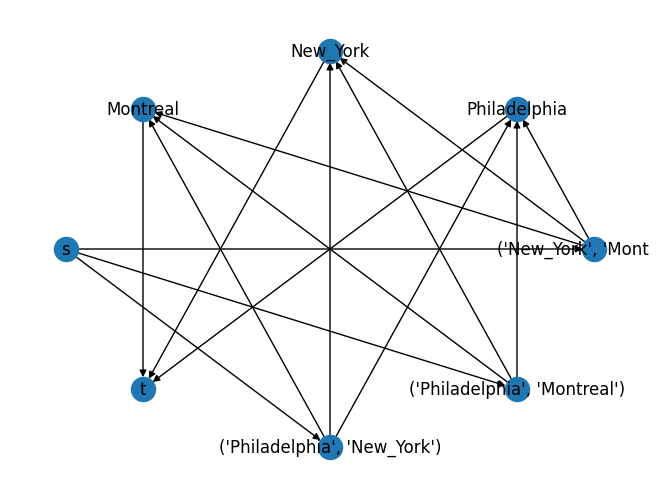

In [ ]:

# for t in teams:
nx.draw_shell(graph, with_labels=True)
plt.show()

In [37]:
g = nx.DiGraph()
g.add_node(1)
g.add_nodes_from([2,3])
g.add_node(4)
g.add_edges_from([(1,2,{'w':0.5}), (1,3,{'w':2}), (2,4,{'w':0.1}), (3,4,{'w':0.2})])

In [38]:
nx.maximum_flow(g,1,4, 'w')

(0.30000000000000004,
 {1: {2: 0.09999999999999998, 3: 0.19999999999999996},
  2: {4: 0.1},
  3: {4: 0.2},
  4: {}})

In [47]:
g[1][2]

{'w': 0.5}

In [48]:
g[1][2]['w'] -= 0.1
g[1][2]#['w']

{'w': 0.4}

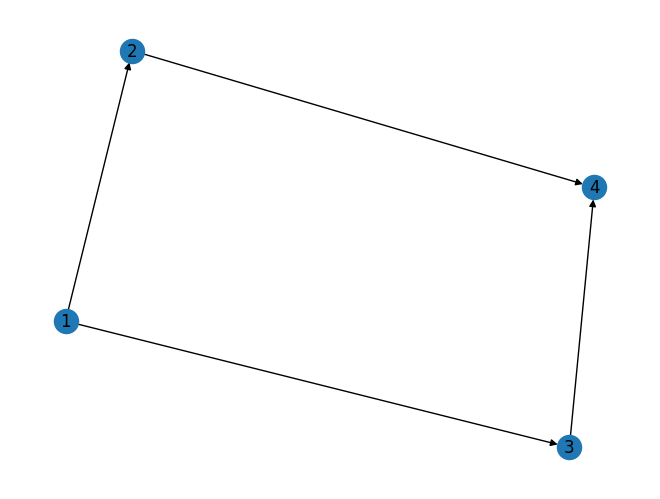

In [ ]:
nx.draw(g, with_labels = True)

In [ ]:

list(graph.predecessors('Montreal'))

[('Philadelphia', 'New_York'),
 ('Philadelphia', 'Montreal'),
 ('New_York', 'Montreal')]

In [4]:
graph['Montreal']['t']

{'final': np.float64(-inf)}

In [11]:
graph[('Philadelphia', 'New_York')]['Philadelphia']['wins'] = np.inf
graph[('Philadelphia', 'New_York')]

AtlasView({'Philadelphia': {'wins': inf}, 'New_York': {'wins': inf}, 'Montreal': {'wins': inf}})

In [5]:
nx.maximum_flow(graph, 's', 'Montreal')

NetworkXUnbounded: Infinite capacity path, flow unbounded above.

In [ ]:
tot_wins = 0
for edge in graph.edges:    
    if edge[-1] == 'Montreal':
        tot_wins += graph[edge[0]][edge[1]]['wins']
    print(tot_wins)

0
0
0
0
0
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


In [39]:
for i in itertools.combinations(test.df['Team'].unique(), 2):
    print(i)

('Atlanta', 'Philadelphia')
('Atlanta', 'New_York')
('Atlanta', 'Montreal')
('Philadelphia', 'New_York')
('Philadelphia', 'Montreal')
('New_York', 'Montreal')


In [21]:
all_rows = []
with open('mlb.txt', 'r') as f:
    data = f.readlines()[1:]
    for row in data:
        entries = row.rstrip().split()
        all_rows.append(entries)

In [29]:
cols = ['Team', 'Wins', 'Losses', 'Remaining', 'Atlanta', 'Philadelphia', 'New_York', 'Montreal']
df = pd.DataFrame(columns = cols, data = all_rows)
for col in cols:
    if col != 'Team':
        df[col] = df[col].astype(int)
df.head()

,Team,Wins,Losses,Remaining,Atlanta,Philadelphia,New_York,Montreal
0,Atlanta,83,71,8,0,1,6,1
1,Philadelphia,80,79,3,1,0,0,2
2,New_York,78,78,6,6,0,0,0
3,Montreal,77,82,3,1,2,0,0


In [ ]:
max_wins = df['Wins'].max()
current_top_team = df[df['Wins'] == df['Wins'].max()]
max_wins

for i in range(len(df)):
    row = df.loc[i]
    if row['Wins'] + row['Remaining'] < current_top_team['Wins']:
        print(f'{row['Team']} has been trivially eliminated by {current_top_team['Team']}')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [5]:
vars = [('acc', {'units': 'm/s^2'}),
        ('vel', {'units': 'm/s'})]
graph.add_nodes_from(vars)
nodes = graph.nodes

In [6]:
type(nodes), nodes['acc']

(networkx.classes.reportviews.NodeView, {'units': 'm/s^2'})

In [7]:
nodes.data()

NodeDataView({'acc': {'units': 'm/s^2'}, 'vel': {'units': 'm/s'}})

In [11]:
graph.add_edge(('Eagles','Cowboys'))
('Cowboys', 'Eagles') in graph.edges

TypeError: Graph.add_edge() missing 1 required positional argument: 'v_of_edge'